# Analysis and Visualization of Complex Agro-Environmental Data
---
## Outlier analysis

This refers to the analytical and graphical processes of identifying and examining data observations that in some way significantly differ from the rest of the dataset. This can be a deviation in terms of values that go much beyond the majority of values of a given variable (univariate outlier) or a combination of values that differ from a given pattern or trend in data (multivariate outlier).


Import modules:

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sts
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stat

### 1. Example of the impact of outliers on descriptive statistics

In the following simple example, let's check the impact of including a single oulier in a dataset on the most common univariate descriptive statistics.

In [2]:
# no outlier
v1 = [1,3,5,2,5,6,8,3,6] # list
v1 = pd.Series(v1) # pandas series
medianv1 = pd.Series({'median': v1.median()})
statv1 = v1.describe()
table1 = pd.concat([medianv1, statv1])

# add outlier (ex. 200)
v2 = [1,3,5,2,5,6,8,3,6,200] # list with outlier
v2 = pd.Series(v2) # pandas series
medianv2 = pd.Series({'median': v2.median()}) # compute median
statv2 = v2.describe() # compute summary statistics table
table2 = pd.concat([medianv2, statv2]) # concatenate series

pd.DataFrame({'No outlier': table1, 'With outlier': table2}) # combine resulting series into a single data frame.

,No outlier,With outlier
median,5.000000,5.000000
count,9.000000,10.000000
mean,4.333333,23.900000
std,2.236068,61.911137
min,1.000000,1.000000
25%,3.000000,3.000000
50%,5.000000,5.000000
75%,6.000000,6.000000
max,8.000000,200.000000


As you can see, the mean and standard deviation changed drastically after adding the outlier. The median and percentiles did not change (in this example). In fact, these location measures are less sensitive to the presence of outliers.

### 2. Detection of outliers

Let's have a look at the dataset `winequality_red.csv` available [here](https://www.kaggle.com/datasets/sgus1318/winedata?resource=download) with 12 variables (columns) related with wine quality characteristics. 


In [4]:
df_wine = pd.read_csv('winequality_red.csv')
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
# Check the size of the dataset
len(df_wine)

1599

#### 2.1 Tukey's Interquartile Range method

Let's first run a univariate scatterplot of the variable 'pH' as well as a boxplot:

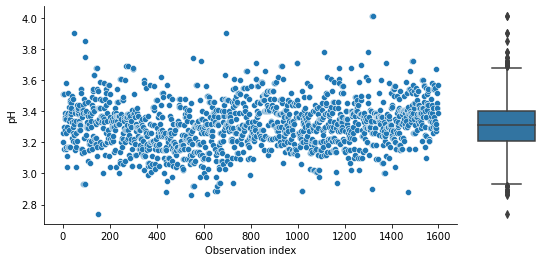

In [6]:
g = sns.JointGrid(data=df_wine, x=df_wine.index, y='pH')
g.plot(sns.scatterplot, sns.boxplot)
g.ax_marg_x.set_axis_off() # removes the marginal x-axis
g.ax_marg_y.set_axis_off() # removes the marginal y-axis
g.ax_marg_x.remove() # removes the marginal x boxplot (index of each observation)
g.set_axis_labels(xlabel='Observation index', ylabel='pH')
g.fig.set_figwidth(8) # to define the width to get a non-square figure with JointGrid 
g.fig.set_figheight(4) # to define the height to get a non-square figure with JointGrid 
plt.show()

This plot shows several outliers in the variable 'pH'. Boxplots are based on the concept of Interquartile Range (IQR) that is used in statistics to measure the statistical dispersion and data variability by dividing the dataset into quartiles. The first, second and fourth quartiles divides the data into four intervals of equal probability: <Q1; Q1-Q2; Q2-Q3; >Q3.

IQR is the difference between the third quartile and the first quartile (IQR = Q3 -Q1). Outliers using this criteria are defined as ***the observations that are below Q1 − 1.5 x IQR (i.e. defining the lower whisker), or above Q3 + 1.5 x IQR (i.e. defining the upper whisker)***.

We can run some code to try to count and detect these outliers:

In [7]:
# function to compute the IQR (upper and lower whisker)

def out_iqr(df , column):
    global loweriqr,upperiqr
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # calculate the IQR
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value
    loweriqr, upperiqr = q25 - cut_off, q75 + cut_off
    # print results
    print('IQR = ',iqr)
    print('lower whisker = ', round(loweriqr, 3))
    print('upper whisker = ', round(upperiqr, 3))
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upperiqr]
    df2 = df[df[column] < loweriqr]
    return print('Total number of outliers = ', df1.shape[0]+ df2.shape[0])

In [8]:
# Get the IQR limits ad the number of outliers
out_iqr(df_wine,'pH')

IQR =  0.18999999999999995
lower whisker =  2.925
upper whisker =  3.685
Total number of outliers =  35


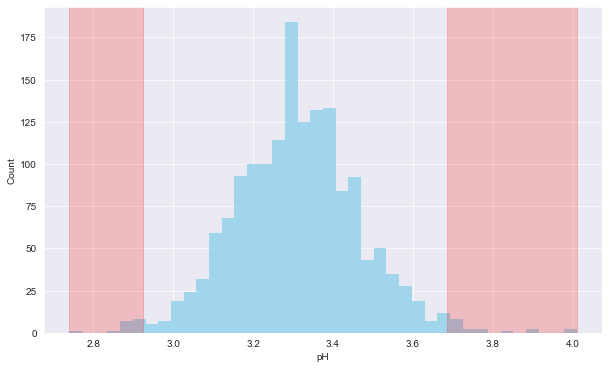

In [9]:
# histogram with areas defining outlier 
plt.figure(figsize = (10,6))
sns.set_style('darkgrid') # set the background to grey with white tckmarks (ggplot default style)
sns.histplot(df_wine.pH,
    color='skyblue',
    edgecolor='none'
    )
plt.axvspan(xmin= df_wine.pH.min(), xmax = loweriqr, alpha=0.2, color='red') # lower was defined by the function 'out_iqr' produced above
plt.axvspan(xmin = upperiqr,xmax= df_wine.pH.max(),alpha=0.2, color='red') # upper was defined by the function 'out_iqr' produced above
plt.show()

In [10]:
# To go back to matplotlib default style run:
plt.style.use('default')

In [11]:
# Get the position (index) of the outliers in the dataset
outlier_indices = np.where((df_wine['pH'] > upperiqr) | (df_wine['pH'] < loweriqr))
print(outlier_indices)
print(np.size(outlier_indices)) # get the number of outliers

(array([  45,   94,   95,  151,  268,  276,  440,  544,  553,  554,  555,
        557,  588,  614,  650,  656,  657,  695,  821,  930,  934,  996,
        997, 1017, 1018, 1111, 1270, 1300, 1316, 1319, 1321, 1377, 1470,
       1488, 1491]),)
35


In [12]:
# add a column to identify the IQR-based outliers
df_wine['Outlier_iqr'] = (df_wine['pH'] < loweriqr) | (df_wine['pH'] > upperiqr)
pd.crosstab(df_wine['Outlier_iqr'], columns='count')

col_0,count
Outlier_iqr,
False,1564
True,35


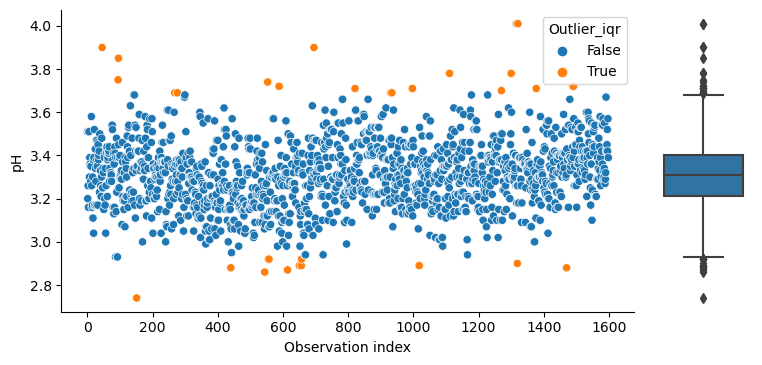

In [13]:
# Visualize the univariate ouliers of the dataset
g = sns.JointGrid(data=df_wine, x=df_wine.index, y='pH', hue='Outlier_iqr')
g.plot(sns.scatterplot, sns.boxplot)
g.ax_marg_x.set_axis_off() # removes the marginal x-axis
g.ax_marg_y.set_axis_off() # removes the marginal y-axis
g.ax_marg_x.remove() # removes the marginal x boxplot (index of each observation)
g.set_axis_labels(xlabel='Observation index', ylabel='pH')
g.fig.set_figwidth(8) # to define the width to get a non-square figure with JointGrid 
g.fig.set_figheight(4) # to define the height to get a non-square figure with JointGrid 
plt.show()

In [14]:
# Remove outliers and create new data frame
df_new = df_wine.loc[(df_wine['pH'] < upperiqr) & (df_wine['pH'] > loweriqr)]
len(df_new)

1564

In [15]:
# Check the impact on univariate summary statstics of removing outliers
# original dataset:
median_pH = pd.Series({'median': df_wine['pH'].median()})
stat_pH = df_wine['pH'].describe()
table1 = pd.concat([median_pH, stat_pH])
# no outliers:
median_pH2 = pd.Series({'median': df_new['pH'].median()})
stat_pH2 = df_new['pH'].describe()
table2 = pd.concat([median_pH2, stat_pH2])

pd.DataFrame({'Original': table1, 'No outliers': table2})

,Original,No outliers
median,3.310000,3.310000
count,1599.000000,1564.000000
mean,3.311113,3.308772
std,0.154386,0.140498
min,2.740000,2.930000
25%,3.210000,3.210000
50%,3.310000,3.310000
75%,3.400000,3.400000
max,4.010000,3.680000


#### 2.2 Standard deviation method

This method uses the standard deviation of the sample as a cut-off for identifying outliers and applies only to data with Gaussian-like distributions,

As we saw, if a data distribution is normal then approximately:

* 68% of the data values lie within one standard deviation of the mean
* 95% are within two standard deviations
* 99.7% lie within three standard deviations.

Outliers may be defined acording to a cutoff value corresponding to 2 times stdev or 3 times stdev.
The code below follows an approach similar to the previous method:

In [16]:
# function to compute detect values below mean - 3xstdev or above mean + 3xstdev that will define the outliers

def out_std(df, column):
    global lowersd, uppersd
    # calculate the mean and standard deviation of the data frame
    data_mean, data_std = df[column].mean(), df[column].std()
    # calculate the cutoff value
    cut_off = data_std * 3
    # calculate the lower and upper bound value
    lowersd, uppersd = data_mean - cut_off, data_mean + cut_off
    print('The lower bound value is', round(lowersd, 3))
    print('The upper bound value is', round(uppersd, 3))
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > uppersd]
    df2 = df[df[column] < lowersd]
    return print('Total number of outliers are', df1.shape[0]+ df2.shape[0])

In [17]:
# Get the 3xSD limits ad the number of outliers
out_std(df_wine,'pH')

The lower bound value is 2.848
The upper bound value is 3.774
Total number of outliers are 8


In [18]:
# add a column to identify the SD-based outliers
df_wine['Outlier_sd'] = (df_wine['pH'] < lowersd) | (df_wine['pH'] > uppersd)
pd.crosstab(df_wine['Outlier_sd'], columns='count')

col_0,count
Outlier_sd,
False,1591
True,8


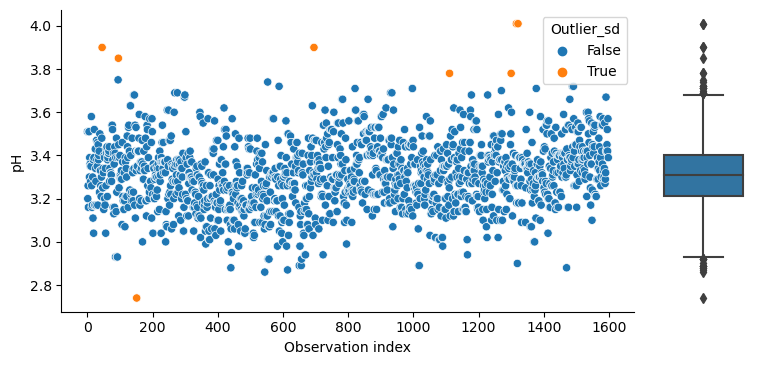

In [19]:
# Visualize the univariate ouliers of the dataset
g = sns.JointGrid(data=df_wine, x=df_wine.index, y='pH', hue='Outlier_sd')
g.plot(sns.scatterplot, sns.boxplot)
g.ax_marg_x.set_axis_off() # removes the marginal x-axis
g.ax_marg_y.set_axis_off() # removes the marginal y-axis
g.ax_marg_x.remove() # removes the marginal x boxplot (index of each observation)
g.set_axis_labels(xlabel='Observation index', ylabel='pH')
g.fig.set_figwidth(8) # to define the width to get a non-square figure with JointGrid 
g.fig.set_figheight(4) # to define the height to get a non-square figure with JointGrid 
plt.show()

This method tends to select fewer outliers. Because outliers increase the standard deviation, the method may fail to detect outliers.

#### 2.3 Z-score method

Z-score describes the position of a raw score in terms of its distance from the mean, when measured in standard deviation units. This method also assumes a Gaussian distribution of the data. The outliers will be defined as the data points that are located in the tails of the distribution.

`Z_score = (Xi - mean) / standard deviation`

where:
* Xi - observation
* 'mean' - mean of all Xi 
* 'standard deviation' - standard deviation of all Xi

An outlier is then a normalized data point which has an absolute value greater than Zthr. That is:
|Z_score| > Zthr

Commonly used Zthr values are 2.5, 3.0 and 3.5. Here we will be using 3.5

Following a similar approach to the previous methods:

In [20]:
# Function to find the lower and the upper cutoff values using the Z-Score method

def out_zscore(data):
    global outliers,zscore
    outliers = []
    zscore = []
    threshold = 3.5
    mean = np.mean(data)
    std = np.std(data)
    for i in data:
        z_score= (i - mean)/std 
        zscore.append(z_score)
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return print("Total number of outliers = ",len(outliers))


In [21]:
# Get the 3xSD limits ad the number of outliers
out_zscore(df_wine['pH'])

Total number of outliers =  5


In [22]:
df_pH = pd.DataFrame(zscore, columns=['pH'])
df_pH

,pH
0,1.288643
1,-0.719933
2,-0.331177
3,-0.979104
4,1.288643
...,...
1594,0.899886
1595,1.353436
1596,0.705508
1597,1.677400


In [23]:
# add a column to identify the SD-based outliers
df_wine['Outlier_zscore'] = (df_pH['pH'] < -3.5) | (df_pH['pH'] > 3.5)
pd.crosstab(df_wine['Outlier_zscore'], columns='count')

col_0,count
Outlier_zscore,
False,1594
True,5


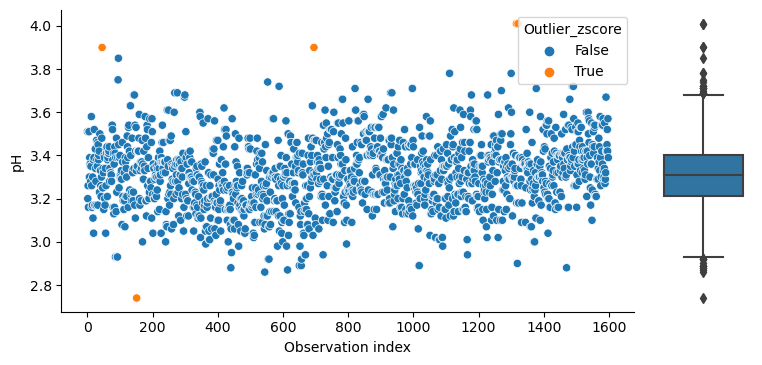

In [24]:
# Visualize the univariate ouliers of the dataset
g = sns.JointGrid(data=df_wine, x=df_wine.index, y='pH', hue='Outlier_zscore')
g.plot(sns.scatterplot, sns.boxplot)
g.ax_marg_x.set_axis_off() # removes the marginal x-axis
g.ax_marg_y.set_axis_off() # removes the marginal y-axis
g.ax_marg_x.remove() # removes the marginal x boxplot (index of each observation)
g.set_axis_labels(xlabel='Observation index', ylabel='pH')
g.fig.set_figwidth(8) # to define the width to get a non-square figure with JointGrid 
g.fig.set_figheight(4) # to define the height to get a non-square figure with JointGrid 
plt.show()

In [ ]:
df_wine

#### 2.4 Isolation Forest

Isolation forest is based recursive partitioning of the dataset using a set of decision trees and provides an anomaly score looking at how isolated the point is in the structure found. The anomaly score is then used to detect outliers. The number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node. THis method is based on the assumption that it requires fewer splits to isolate an outlier than it does to isolate a non-outlier, i.e. an outlier has a lower isolation number in comparison to a non-outlier observation. 

An observation is therefore defined as an outlier if its isolation number is lower than a given threshold. The threshold is defined based on the estimated percentage of outliers in the data, which is the starting point of this outlier detection algorithm.

Isolation Forest does not assume normal distribution and is able to detect outliers at a multi-dimensional level. Moreover, the algorithm has a linear time complexity with a low constant and a low memory requirement which makes it computationally efficient. Hence, it scales well to large data sets.

The method is implemented in the scikit-learn module: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In the following code, examples of how to identify ***univariate, bivariate and multivariate outliers*** are provided.

In [25]:
#Import necessary libraries
from sklearn.ensemble import IsolationForest

##### 2.4.1 Run a univariate isolation forest (to detect univariate outliers)

Let's run a univariate isolation forest for 'pH'

In [26]:
model = IsolationForest(n_estimators = 150, contamination='auto') # define the model (150 isolation trees, default: only 1 variable (feature) of the dataset)
model.fit(df_wine['pH'].values.reshape(-1,1)) # fit the model (univariate: 'pH')
scores = model.decision_function(df_wine['pH'].values.reshape(-1,1)) #  extract the anomaly scores (mean anomaly scores of each tree)
anomaly = model.predict(df_wine['pH'].values.reshape(-1,1)) # extract an anomaly (outlier) identifier (-1)
df_wine['scores'] = scores # add a new column to the database with the anomaly scores
df_wine['anomaly'] = anomaly # add a new column to the database with the anomaly identifier (1/-1)
pd.crosstab(df_wine['anomaly'], columns='count') # count the number of outliers

col_0,count
anomaly,
-1,368
1,1231


Visualize the univariate ouliers of the dataset

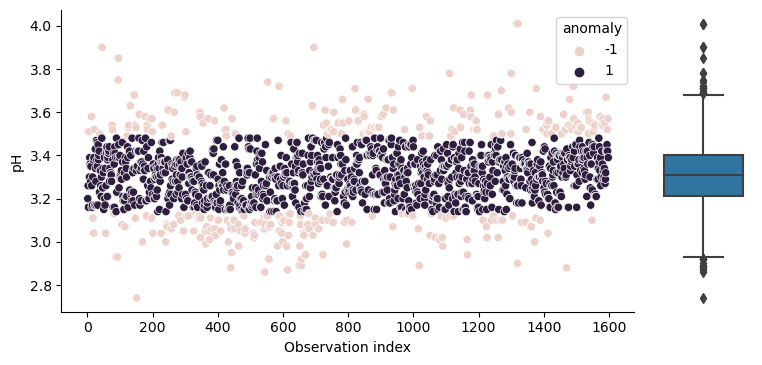

In [27]:
g = sns.JointGrid(data=df_wine, x=df_wine.index, y='pH', hue='anomaly')
g.plot(sns.scatterplot, sns.boxplot)
g.ax_marg_x.set_axis_off() # removes the marginal x-axis
g.ax_marg_y.set_axis_off() # removes the marginal y-axis
g.ax_marg_x.remove() # removes the marginal x boxplot (index of each observation)
g.set_axis_labels(xlabel='Observation index', ylabel='pH')
g.fig.set_figwidth(8) # to define the width to get a non-square figure with JointGrid 
g.fig.set_figheight(4) # to define the height to get a non-square figure with JointGrid 
plt.show()

##### 2.4.2 Run a bivariate isolation forest

Let's now run a bivariate isolation forest for'pH' and 'citric acid'

In [28]:
model = IsolationForest(n_estimators = 150, contamination='auto', max_features=2) # define the model (150 isolation trees, default: only 1 variable (feature) of the dataset)
model.fit(df_wine[['citric acid', 'pH']].values) # fit the model (univariate: 'pH')
scores = model.decision_function(df_wine[['citric acid', 'pH']].values) #  extract the anomaly scores (mean anomaly scores of each tree)
anomaly = model.predict(df_wine[['citric acid', 'pH']].values) # extract an anomaly (outlier) identifier (-1)
df_wine['scores'] = scores # add a new column to the database with the anomaly scores
df_wine['anomaly'] = anomaly # add a new column to the database with the anomaly identifier (1/-1)
pd.crosstab(df_wine['anomaly'], columns='count') # count the number of outliers

col_0,count
anomaly,
-1,405
1,1194


Visualize the bivariate ouliers of the dataset

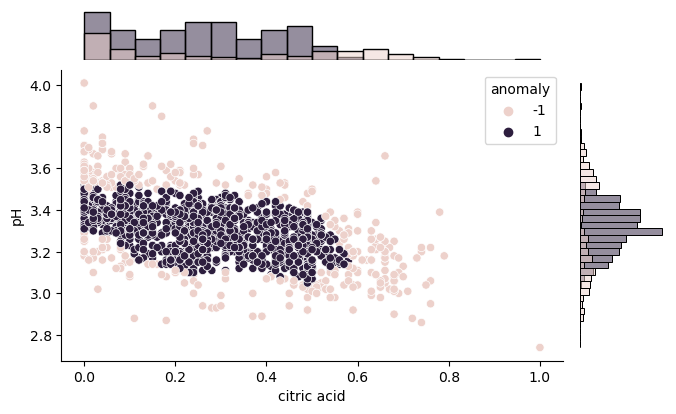

In [30]:
g = sns.JointGrid(data=df_wine, x='citric acid', y='pH', hue='anomaly') 
g.plot(sns.scatterplot, sns.histplot) # to plot both a scatter plot and a boxplot for each variable
g.ax_marg_x.set_axis_off() # removes the marginal x-axis
g.ax_marg_y.set_axis_off() # removes the marginal y-axis
g.fig.set_figwidth(7) # to define the width to get a non-square figure with JointGrid 
g.fig.set_figheight(4) # to define the height to get a non-square figure with JointGrid 
plt.show()

Alternative using continuous anomaly scores instead (may take a while).

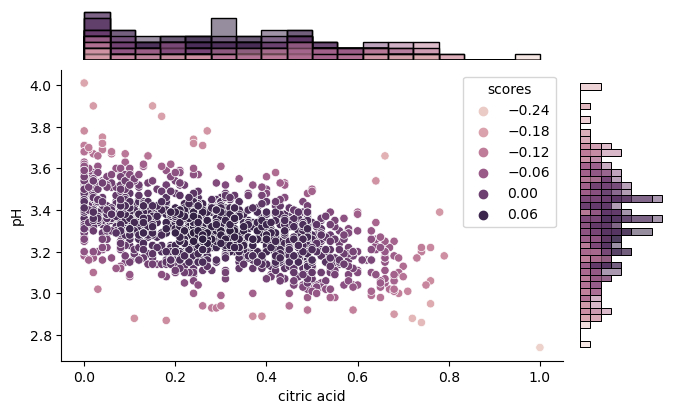

In [31]:
g = sns.JointGrid(data=df_wine, x='citric acid', y='pH', hue='scores') 
g.plot(sns.scatterplot, sns.histplot) # to plot both a scatter plot and a boxplot for each variable
g.ax_marg_x.set_axis_off() # removes the marginal x-axis
g.ax_marg_y.set_axis_off() # removes the marginal y-axis
g.fig.set_figwidth(7) # to define the width to get a non-square figure with JointGrid 
g.fig.set_figheight(4) # to define the height to get a non-square figure with JointGrid 
plt.show()

##### 2.4.3 Run a multivariate isolation forest

Let's now run a bivariate isolation forest for all variables in the dataset (including categorical)

In [ ]:
model = IsolationForest(n_estimators = 150, contamination='auto', max_features=12) # define the model (150 isolation trees, all 12 variables in the dataset)
model.fit(df_wine.values) # fit the model to the data
scores = model.decision_function(df_wine.values) # extract the anomaly scores (mean anomaly scores of each tree)
anomaly = model.predict(df_wine.values) # to extract an anomaly (outlier) identifier (-1)
df_wine['scores'] = scores # add a new column to the database with the anomaly scores
df_wine['anomaly'] = anomaly # add a new column to the database with the anomaly identifier(1/-1)
pd.crosstab(df_wine['anomaly'], columns='count') # count the number of outliers

Visualize the multivariate ouliers of the dataset using a univariate plot for 'pH' (just as an example).

NOTE: It is dificult to visualize outliers for more than 2 dimensions (maybe a biplot of a Principal Component Analysis would help).

In [ ]:
g = sns.JointGrid(data=df_wine, x=df_wine.index, y='pH', hue='anomaly')
g.plot(sns.scatterplot, sns.boxplot)
g.ax_marg_x.set_axis_off() # removes the marginal x-axis
g.ax_marg_y.set_axis_off() # removes the marginal y-axis
g.ax_marg_x.remove() # removes the marginal x boxplot (index of each observation)
g.set_axis_labels(xlabel='Observation index', ylabel='pH')
g.fig.set_figwidth(8) # to define the width to get a non-square figure with JointGrid 
g.fig.set_figheight(4) # to define the height to get a non-square figure with JointGrid 
plt.show()

In [56]:
import pandas as pd
from scipy.stats import chi2_contingency

# Load the dataset
df = pd.read_csv('EFIplus_medit.zip',compression='zip', sep=";")


# Contingency table of presence/absence of Salmo trutta fario vs. country
contingency_table = pd.crosstab(df['Salmo trutta fario'], df['Country'])
print(contingency_table)

# Perform chi-square test of independence
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print("H0: means are equal")
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_val)

if p_val>0.05 :
    print ("H0 is accepeted")
else:
    print("H0 is rejected")

Country             France  Italy  Portugal  Spain
Salmo trutta fario                                
0                       13    109       615   1239
1                       59     76       252   2648
H0: means are equal
Chi-square statistic: 496.3723854072799
P-value: 2.9162328651936495e-107
H0 is rejected


EXERCICE 2

In [60]:
from scipy.stats import kruskal


top_8_catchments = df['Catchment_name'].value_counts().head(8).index.tolist()
print(top_8_catchments)
elevation_dict = {}

for catchment in top_8_catchments:
    elevation_list = df[df['Catchment_name'] == catchment]['Elevation_mean_catch'].tolist()
    elevation_dict[catchment] = elevation_list

# Extract elevation values for each catchment site
elevation_values = [np.array(elevation_dict[catchment]) for catchment in top_8_catchments]
elevation_values = [values[~np.isnan(values)] for values in elevation_values]

from scipy.stats import kruskal

# Perform Kruskal-Wallis H test
h_statistic, p_value_kw = kruskal(*elevation_values)

print("Kruskal-Wallis H Test Results:")
print("H0: means are equal")
print("H-Statistic:", h_statistic)
print("P-Value:", p_value_kw)
print("H0 is rejected")

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(*elevation_values)

print("One-Way ANOVA Results:")
print("H0: means are equal")
print("F-Statistic:", f_statistic)
print("P-Value:", p_value)
print("H0 is rejected")


#The result of the parametric and non parametric test are the same. Inthe both case we reject H0.

# Post-hoc Tukey's HSD test for pairwise comparisons
print("H0: means are equal")
tukey_results = pairwise_tukeyhsd(np.concatenate(elevation_values), np.concatenate([[i]*len(values) for i, values in enumerate(elevation_values)]))
print("\nTukey's HSD Results:")
print(tukey_results)



print("No significatives difference for Galiza-Norte/Guadia ; Mihno/Douro ; Cantabrica/Catala")


['Ebro', 'Galiza-Norte', 'Minho', 'Tejo', 'Cantabrica', 'Douro', 'Guadia', 'Catala']
Kruskal-Wallis H Test Results:
H0: means are equal
H-Statistic: 1335.3732750709976
P-Value: 3.7056116510329714e-284
H0 is rejected
One-Way ANOVA Results:
H0: means are equal
F-Statistic: 227.9539828360388
P-Value: 1.369526482034513e-285
H0 is rejected
H0: means are equal

Tukey's HSD Results:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
     0      1 -651.7093  0.001 -710.5323 -592.8862   True
     0      2 -176.4404  0.001 -235.3052 -117.5756   True
     0      3 -299.1072  0.001  -364.079 -234.1353   True
     0      4 -467.4299  0.001 -535.0623 -399.7974   True
     0      5 -199.2714  0.001 -268.7939  -129.749   True
     0      6 -636.3246  0.001 -712.0552 -560.5939   True
     0      7 -417.2415  0.001 -503.2604 -331.2227   True
     1      2  475.2688  0.001  416.2804 

EXERCICE 3

In [74]:
#Testing the normality of the data

normality_results = []

# Iterate over each column
for column in data.columns:
    # Check if column contains numeric data
    if pd.api.types.is_numeric_dtype(data[column]):
        # Perform Shapiro-Wilk test for normality
        statistic, p_value = shapiro(data[column])
        
        # Determine normality based on the p-value
        normality = 'Normal' if p_value > 0.05 else 'Not Normal'

        # Append results to the list
        normality_results.append({'Column': column,
                                  'Test Statistic': statistic,
                                  'P-value': p_value,
                                  'Normality': normality})

# Convert the list of results into a DataFrame
normality_results_df = pd.DataFrame(normality_results)

# Display the summary table
print(normality_results_df)


# Data are not normal so we gonna use a non parametric tets (mann U test)



                  Column  Test Statistic       P-value   Normality
0          fixed acidity        0.942031  1.525595e-24  Not Normal
1       volatile acidity        0.974334  2.686807e-16  Not Normal
2            citric acid        0.955290  1.020820e-21  Not Normal
3         residual sugar        0.566077  0.000000e+00  Not Normal
4              chlorides        0.484247  0.000000e+00  Not Normal
5    free sulfur dioxide        0.901841  7.697398e-31  Not Normal
6   total sulfur dioxide        0.873225  3.574144e-34  Not Normal
7                density        0.990867  1.940096e-08  Not Normal
8                     pH        0.993487  1.713695e-06  Not Normal
9              sulphates        0.833043  5.821618e-38  Not Normal
10               alcohol        0.928839  6.643665e-27  Not Normal
11               quality        0.857584  9.504004e-36  Not Normal


In [80]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import mannwhitneyu


#HERE THE STRATEGY IS TO MAKE A U TEST FOR EACH VARIABLE BETWEEN GOOD AND BAD WINE AND SORT BY ASCENDING ORDER THE P VALUE TO DETERMINE THE MOST IMPORTANT VARIABLE

# Load the dataset
data = pd.read_csv('winequality_red.csv')
data.dropna(inplace=True)
threshold = 5
data['quality_class'] = data['quality'].apply(lambda x: 'good' if x > threshold else 'bad')


mannwhitneyu_results = []

# Iterate over each column
for column in data.columns[:-1]:  # Exclude the last column ('quality_class')
    # Split data into 'good' and 'bad' quality groups
    good_quality = data[data['quality_class'] == 'good'][column]
    bad_quality = data[data['quality_class'] == 'bad'][column]
    
    # Perform Mann-Whitney U test
    statistic, p_value = mannwhitneyu(good_quality, bad_quality)
    
    # Append results to the list
    mannwhitneyu_results.append({'Column': column,
                                 'Test Statistic': statistic,
                                 'P-value': p_value})

# Convert the list of results into a DataFrame
mannwhitneyu_results_df = pd.DataFrame(mannwhitneyu_results)


# Sort the results DataFrame by P-value in ascending order
sorted_results = mannwhitneyu_results_df.sort_values(by='P-value')

# Display the sorted DataFrame
print(sorted_results)






## MACHINE LEARNING METHOD TO COMPARE RESULTS

# Define the target variable and features



X = data.drop(['quality', 'quality_class'], axis=1)
y = data['quality_class']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get feature importances
feature_importances = clf.feature_importances_

# Create DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the most important features

print("machine learning method")
print("Top features discriminating wine quality:")
print(feature_importance_df)


#we have alsmost the same result with the two methods so we can conclude that the U test method works



                  Column  Test Statistic        P-value
11               quality             0.0  8.119167e-305
10               alcohol        154807.0   1.003030e-70
9              sulphates        195152.0   5.889734e-41
1       volatile acidity        197208.0   1.194237e-39
6   total sulfur dioxide        245006.0   1.068071e-15
4              chlorides        254091.0   1.859553e-12
7                density        257552.0   2.509611e-11
2            citric acid        259847.5   1.277344e-10
0          fixed acidity        288224.5   5.967745e-04
5    free sulfur dioxide        298401.5   1.631983e-02
3         residual sugar        312969.5   2.898717e-01
8                     pH        316157.5   4.181711e-01
machine learning method
Top features discriminating wine quality:
                 Feature  Importance
10               alcohol    0.191171
9              sulphates    0.130427
1       volatile acidity    0.106271
6   total sulfur dioxide    0.095007
7                dens

### Conclusion

The different detection methods differ greatly leading to marked differences in outlier detection. It is important to detect outliers by finding consensus among different methods. After detecting outliers, it important to assess whether they correspond to real data as well as to evaluate their impact on the analytical methods we intend to use. Based on this assessment, we may use different approaches to deal with them.

There are many other methods for outlier detection processes that you may search for, such as:
- DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
- Local Outlier Factor Method (LOF):
- Elliptic Envelope
- One-Class Support Vector Machines
- Robust Random Cut Forest

### References

https://www.analyticsvidhya.com/blog/2021/06/univariate-anomaly-detection-a-walkthrough-in-python/

https://www.kaggle.com/code/rpsuraj/outlier-detection-techniques-simplified

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

